Select mode here.

In [1]:
mode = 'SN Ia'
# mode = 'SN II'
# mode = 'SLSN-I'
# mode = 'SN IIP'
# mode = 'SN IIb'
# mode = 'SN IIn'
# mode = 'SN Ibc'

if ' ' in mode:
    modestr = mode.replace(' ','')

In [2]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
from matplotlib import pyplot as plt
import corner
import urllib
import os
import sys
import GCRCatalogs
from astropy.io import fits
from sklearn.model_selection import train_test_split
import pandas as pd
from astropy.cosmology import Planck15 as P15
from astropy import units as u
import matplotlib
import time
import seaborn as sns
from collections import Counter


In [3]:
cosmo = GCRCatalogs.load_catalog("cosmoDC2_v1.1.4_small")

In [4]:
r = cosmo.get_quantities('mag_true_r_lsst')

In [5]:
np.amax(r['mag_true_r_lsst'])

34.824368

In [3]:
def abs_to_apparent(M, z):
    d = (P15.luminosity_distance(z).to(u.pc)).value
    m = M + 5 * np.log10(d) - 5
    return m
def apparent_to_abs(m,z):
    d = (P15.luminosity_distance(z).to(u.pc)).value
    M = -1*(5 * np.log10(d) - m)
    return M

Index(['TransientClass', 'objID', 'raMean', 'decMean', 'NED_redshift',
       'TransientRedshift', 'gKronMag', 'gApMag', 'gPSFMag', 'rKronMag',
       'rApMag', 'rPSFMag', 'iKronMag', 'iApMag', 'iPSFMag', 'zKronMag',
       'zApMag', 'zPSFMag', 'yKronMag', 'yApMag', 'yPSFMag', 'gKronMagErr',
       'gApMagErr', 'gPSFMagErr', 'rKronMagErr', 'rApMagErr', 'rPSFMagErr',
       'iKronMagErr', 'iApMagErr', 'iPSFMagErr', 'zKronMagErr', 'zApMagErr',
       'zPSFMagErr', 'yKronMagErr', 'yApMagErr', 'yPSFMagErr', 'g-r', 'r-i',
       'i-z', 'z-y', 'g-rErr', 'r-iErr', 'i-zErr', 'z-yErr', 'g_ellip',
       'r_ellip', 'i_ellip', 'z_ellip', 'g-r_SDSS_rest', 'r-i_SDSS_rest',
       'i-z_SDSS_rest', 'y_ellip', 'g_elong', 'r_elong', 'i_elong', 'z_elong',
       'y_elong', 'gKronMag_SDSS_abs', 'rKronMag_SDSS_abs',
       'iKronMag_SDSS_abs', 'zKronMag_SDSS_abs'],
      dtype='object')
12136
Number of SN Ia: 8390
original length:  8390
Redshift = nan cut, cut to:  7855
Multiple nans cut, cut to  7855


/global/u2/m/mlokken/mydescdev/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less
/global/u2/m/mlokken/mydescdev/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater


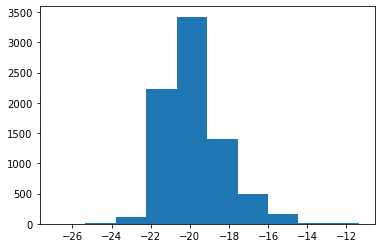

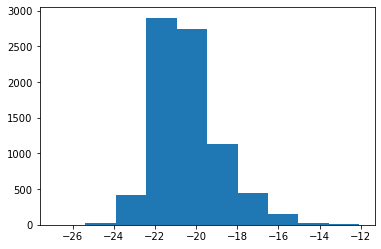

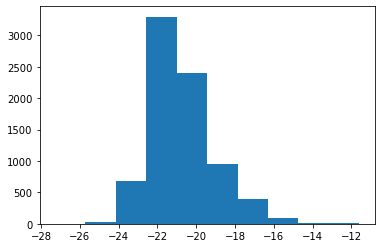

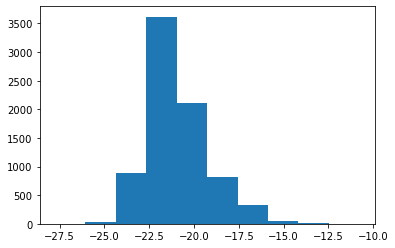

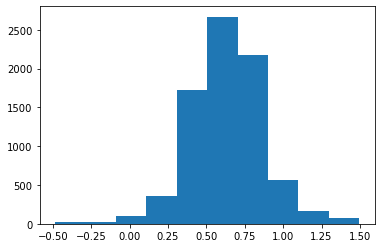

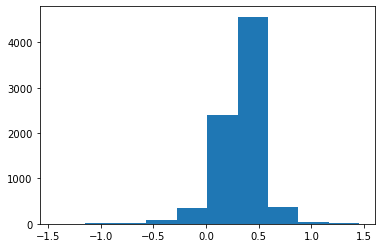

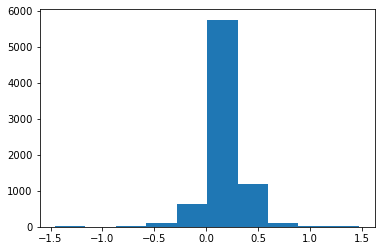

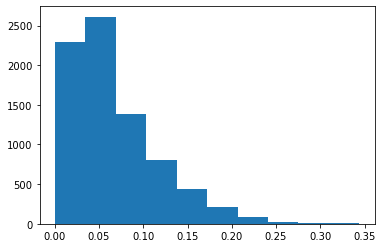

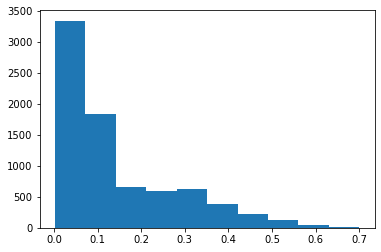

<Figure size 432x288 with 0 Axes>

In [4]:
# Import GHOST data
file = '../data_files/GHOST_restFrame_condenseLabels_0323.csv'
ghost = pd.read_csv(file)
print(ghost.columns)
print(len(ghost))
# First group by transient class
if mode == 'SN II':
    a = ghost['TransientClass']==mode
    b = ghost['TransientClass']=='SN IIP'
    c = ghost['TransientClass']=='SN IIb'
    d = ghost['TransientClass']=='SN IIn'
    ghost = ghost[np.logical_or(np.logical_or(np.logical_or(a,b),c), d)]
elif mode == 'SN Ibc':
    a = ghost['TransientClass'] == 'SN Ib'
    b = ghost['TransientClass'] == 'SN Ic'
    c = ghost['TransientClass'] == 'SLSN-I' # lump in SLSN hosts because there are too few of them for it to be its own hostlib                    
    ghost = ghost[np.logical_or(np.logical_or(a,b),c)]
else:
    ghost = ghost[ghost['TransientClass'] == mode]
ghost.reset_index(inplace=True)
print("Number of {:s}: {:d}".format(mode,len(ghost)))
transient_class = ghost['TransientClass']
gMag_G = ghost['gKronMag_SDSS_abs']
gMag_R = ghost['rKronMag_SDSS_abs']
gMag_I = ghost['iKronMag_SDSS_abs']
gMag_Z = ghost['zKronMag_SDSS_abs']
g_rshift = ghost['NED_redshift']
g_rshift2 = ghost['TransientRedshift']
g_ellip  = ghost['r_ellip']
g_gr   = ghost['g-r_SDSS_rest']
g_ri   = ghost['r-i_SDSS_rest']
g_iz   = ghost['i-z_SDSS_rest']

# keep track of indices from original file
og_ghost_idx = np.arange(len(ghost))
keydata = np.vstack((gMag_G, gMag_R, gMag_I, gMag_Z, g_gr, g_ri, g_iz, g_ellip, g_rshift, g_rshift2)).T

# first remove all -999s:

keydata[np.logical_or(keydata<-50,keydata>100)] = np.nan

print("original length: ", len(keydata))

# get rid of redshifts with nan
delete_znans = []
z_nans = 0
for i in range(len(keydata)):
    if np.isnan(keydata[i,8]):
        z_nans += 1
for i in range(len(keydata)):
    if np.isnan(keydata[i,8]):
        # if transient redshift is not nan, replace with transient redshift
        if not np.isnan(keydata[i,9]):
            keydata[i,8] = keydata[i,9]
        else:
            delete_znans.append(i)
    if keydata[i,8] <= 0:
        delete_znans.append(i)

keydata = np.delete(keydata, delete_znans, axis=0)
og_ghost_idx = np.delete(og_ghost_idx, delete_znans)

print("Redshift = nan cut, cut to: ", len(keydata))

delete_rows = []
# delete rows with more than one nan
for i in range(len(keydata)):
    if np.isnan(np.sum(keydata[i])):
        nan_counter = 0
        for j in range(1, len(keydata[i])):
            if np.isnan(keydata[i,j]):
                nan_counter+=1
        if nan_counter > 1:
            delete_rows.append(i)
#     for j in range(2,6): # the magnitudes
#         if keydata[i,j]<0 or keydata[i,j]>25.:
#             delete_rows.append(i)

keydata = np.delete(keydata, delete_rows, axis=0)
og_ghost_idx = np.delete(og_ghost_idx, delete_rows)
print("Multiple nans cut, cut to ", len(keydata))

# finally for rows with just one nan, replace with the average value
for i in range(len(keydata)):
    if np.isnan(np.sum(keydata[i])):
        for j in range(1, len(keydata[i])):
            if np.isnan(keydata[i,j]):
                keydata[i,j] = np.nanmean(keydata[:,j])


for i in range(9):
    plt.hist(keydata[:,i])
    plt.show()
    plt.clf()


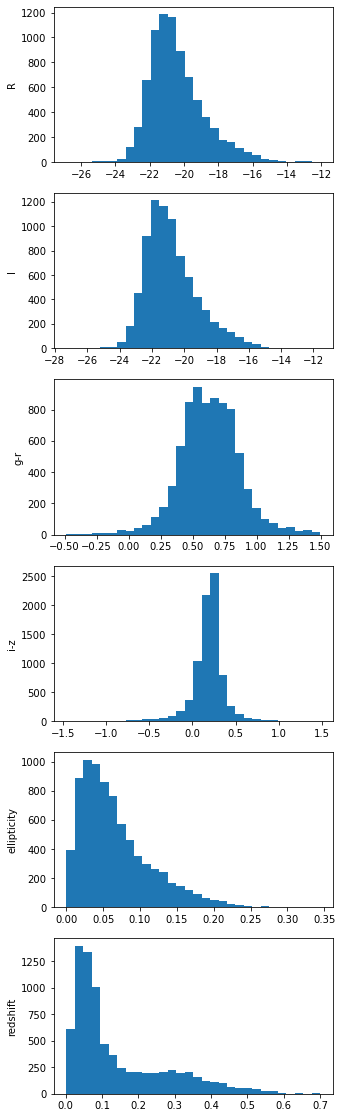

In [5]:
gG = keydata[:,0]
gR = keydata[:,1]
gI = keydata[:,2]
gZ = keydata[:,3]
g_gr = keydata[:,4]
g_ri   = keydata[:,5]
g_iz   = keydata[:,6]
g_ellip = keydata[:,7]
g_rshift = keydata[:,8]

data_keyparams = np.vstack((gR, gI, g_gr, g_iz, g_ellip, g_rshift)).T
fig, ax = plt.subplots(nrows=6, ncols=1, figsize=[5,20])
xlabel_list = ['R', 'I', 'g-r', 'i-z', 'ellipticity', 'redshift']
for i in range(data_keyparams.shape[1]):
    ax[i].hist(data_keyparams[:,i], bins=30)
    ax[i].set_ylabel(xlabel_list[i])


### Load the CosmoDC2 galaxies which have been shifted in z and SFR by PZFlow.
First cut them down to R<-15

In [6]:
# resampled = pd.read_csv("/global/cscratch1/sd/mlokken/sn_hostenv/DC2_pzRedshifts_SFR_new.csv")
# resampled = resampled[resampled['Mag_true_r_sdss_z0']<-15.]
# resampled.reset_index(inplace=True)
# resampled.to_csv("/global/cscratch1/sd/mlokken/sn_hostenv/DC2_pzRedshifts_SFR_RMag_lt_neg15.csv")

In [7]:
# resampled = pd.read_csv("/global/cscratch1/sd/mlokken/sn_hostenv/DC2_pzRedshifts_SFR_RMag_lt_neg15.csv")
# max(resampled['Mag_true_r_sdss_z0'])

# cG = resampled['Mag_true_g_sdss_z0']
# cR = resampled['Mag_true_r_sdss_z0']
# cI = resampled['Mag_true_i_sdss_z0']
# cZ = resampled['Mag_true_z_sdss_z0']
# c_ellip = resampled['morphology/totalEllipticity']
# c_gr = cG-cR
# c_iz = cI-cZ

# idx = np.random.choice(np.arange(len(c_gr)), size=100000, replace=False)
# plt.plot(resampled['PZflowredshift'][idx], c_gr[idx], 'ro', markersize=2, alpha=0.01)
# plt.ylabel("g-r")
# plt.xlabel("PZflow Redshift")
# plt.title("Subsample from CDC2, pre-matching")

# idx = np.random.choice(np.arange(len(cI-cZ)), size=100000, replace=False)
# plt.plot(c_iz[idx], c_gr[idx], 'ro', markersize=2, alpha=0.03)
# plt.ylabel("g-r")
# plt.xlabel("i-z")
# # plt.xlim([0,.3])
# # plt.ylim([0,0.8])
# plt.title("Subsample from CDC2, pre-matching")

# limit sample

# keep = (c_iz < 0.5)&(c_iz>-0.18)
# resampled_limit = resampled.loc[keep]
# resampled_limit.reset_index(inplace=True)

# cG = resampled_limit['Mag_true_g_sdss_z0']
# cR = resampled_limit['Mag_true_r_sdss_z0']
# cI = resampled_limit['Mag_true_i_sdss_z0']
# cZ = resampled_limit['Mag_true_z_sdss_z0']
# c_ellip = resampled_limit['morphology/totalEllipticity']
# c_rshift = resampled_limit['PZflowredshift']
# c_gr = cG-cR
# c_iz = cI-cZ


# idx = np.random.choice(np.arange(len(cI-cZ)), size=100000, replace=False)
# plt.plot(c_iz.loc[idx], c_gr.loc[idx], 'ro', markersize=2, alpha=0.03)
# plt.ylabel("g-r")
# plt.xlabel("i-z")
# # plt.xlim([0,.3])
# # plt.ylim([0,0.8])
# plt.title("Subsample from CDC2, pre-matching")

# resampled_limit.to_csv("/global/cscratch1/sd/mlokken/sn_hostenv/DC2_pzRedshifts_SFR_RMag_lt_neg15_colorlim.csv")

# plt.plot(cI[idx], c_iz.loc[idx], 'ro', markersize=2, alpha=0.03)
# plt.ylabel("g-r")
# plt.xlabel("i-z")
# # plt.xlim([0,.3])
# # plt.ylim([0,0.8])
# plt.title("Subsample from CDC2, pre-matching")

In [8]:
resampled = pd.read_csv("/global/cscratch1/sd/mlokken/sn_hostenv/DC2full_pzRedshifts_SFR_39iter.csv")
cG = resampled['Mag_true_g_sdss_z0']
cR = resampled['Mag_true_r_sdss_z0']
cI = resampled['Mag_true_i_sdss_z0']
cZ = resampled['Mag_true_z_sdss_z0']
c_ellip = resampled['morphology/totalEllipticity']
c_rshift = resampled['PZflowredshift']
c_gr = cG-cR
c_iz = cI-cZ

In [9]:
keep = (c_iz < 0.5)&(c_iz>-0.18)
resampled_limit = resampled.loc[keep]
resampled_limit.reset_index(inplace=True)

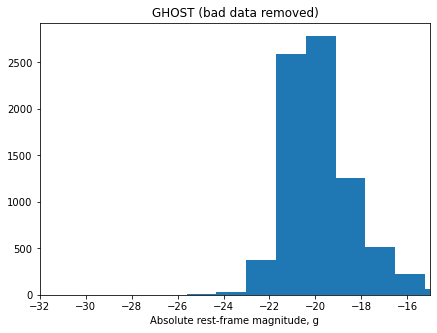

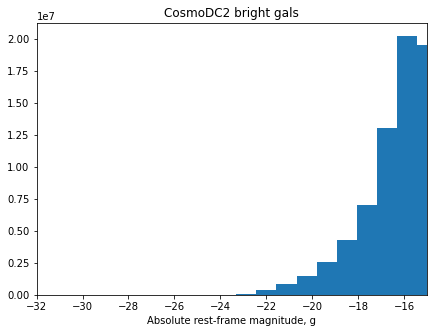

In [10]:
plt.figure(figsize=[7,5])
plt.hist(gG, bins=12)
plt.xlabel("Absolute rest-frame magnitude, g")
plt.xlim([-32,-15])
plt.title("GHOST (bad data removed)")
plt.show()
plt.figure(figsize=[7,5])
plt.hist(cG, bins=12)
plt.title("CosmoDC2 bright gals")
plt.xlabel("Absolute rest-frame magnitude, g")
plt.xlim([-32,-15])
plt.show()

### Make sets of the key parameters we want to match
> I have chosen (redshift, g-r, r-i, i-z, r, ellipticity) after testing different combinations of parameters. The goal is to make a sample of the Buzzard galaxies which, when fed through EmpiriciSN, generates similar light curves as the training sample. My chosen parameters achieve this goal decently, but may not be the most ideal choice.
> Matching on all possible parameters is actually not ideal because nearest-neighbors does not work well in high-dimensional space.

In [11]:
sim_keyparams= np.vstack((cR, cI, c_gr, c_iz, c_ellip, c_rshift)).T


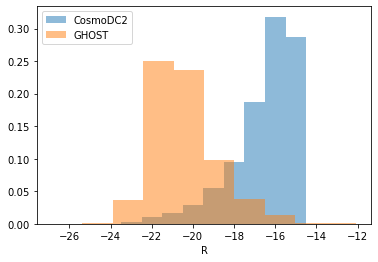

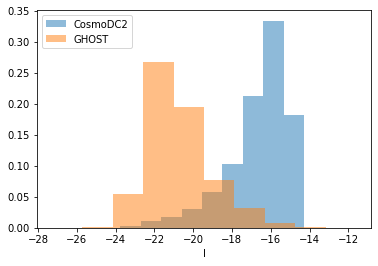

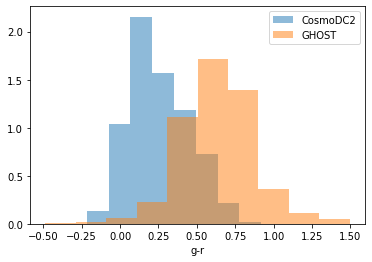

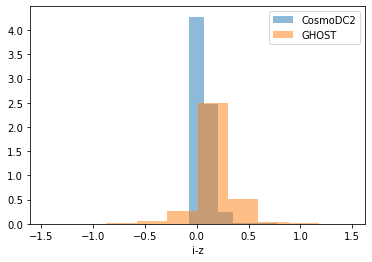

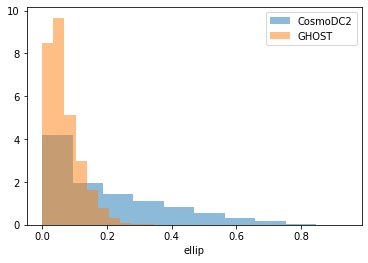

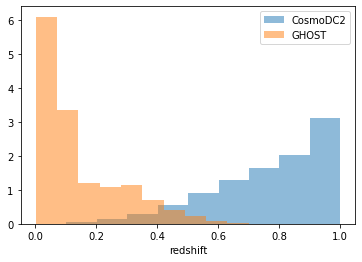

<Figure size 432x288 with 0 Axes>

In [12]:
feature_names = ['R', 'I', 'g-r', 'i-z', 'ellip', 'redshift']
# sim_keyparams_df = pd.DataFrame(sim_keyparams, columns=feature_names)
# data_keyparams_df = pd.DataFrame(data_keyparams, columns=feature_names)
# keyparams_df = pd.concat([sim_keyparams_df.assign(dataset='set1'), data_keyparams_df.assign(dataset='set2')])


for i in range(sim_keyparams.shape[1]):
    plt.hist(sim_keyparams[:,i], density=True, alpha=0.5, label='CosmoDC2')
    plt.hist(data_keyparams[:,i], density=True, alpha=0.5, label="GHOST")
    plt.xlabel(feature_names[i])
    plt.legend()
    plt.show()
    plt.clf()

[-16.51397091 -16.6374201    0.25481955   0.06566371   0.1987066
   0.7667618 ]


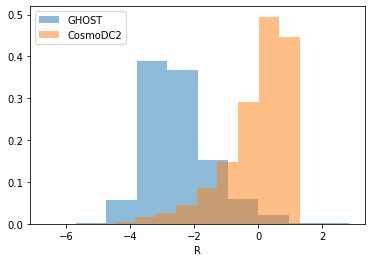

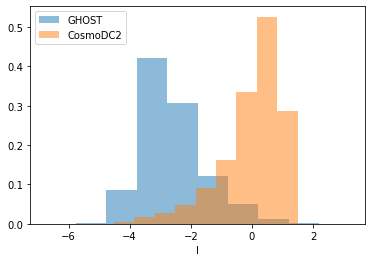

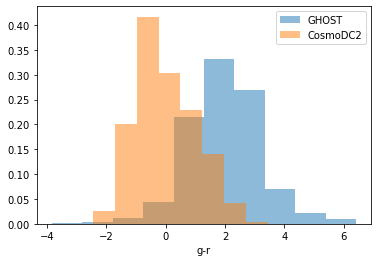

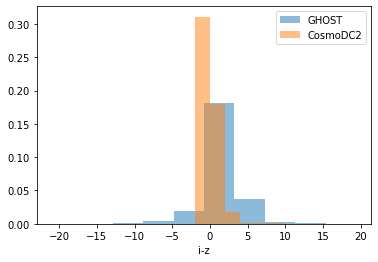

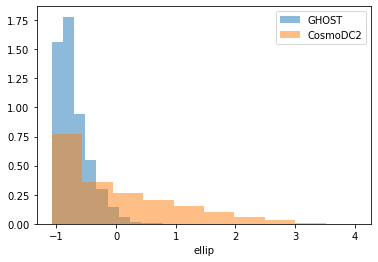

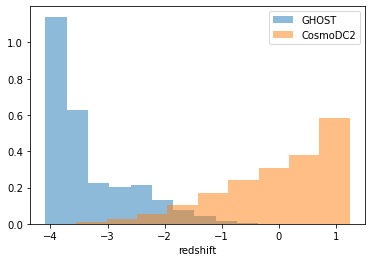

<Figure size 432x288 with 0 Axes>

In [13]:
def min_max_normalize(feature, feature_name):
    norm_feature = (feature - np.amin(feature))/(np.amax(feature)-np.amin(feature))
    plt.hist(norm_feature)
    plt.title(feature_name)
    plt.show()
    plt.clf()
    return(norm_feature)

# normalize for knn
# The purpose of is this is so that the nearest-neighbors algorithm is searching in a multidimensional space
# where typical distances are similar in all dimensions

from sklearn.preprocessing import StandardScaler
ghost_cdc2 = np.vstack((data_keyparams, sim_keyparams))
scaler = StandardScaler()
scaler.fit(ghost_cdc2)
print(scaler.mean_)
keyparams_norm = scaler.transform(ghost_cdc2)
data_keyparams_norm = keyparams_norm[0:len(data_keyparams[:,0]),:]
sim_keyparams_norm  = keyparams_norm[len(data_keyparams[:,0]):,:]
for i in range(len(data_keyparams[0])):
    plt.hist(data_keyparams_norm[:,i], density=True, alpha=0.5, label='GHOST')
    plt.hist(sim_keyparams_norm[:,i], density=True, alpha=0.5, label='CosmoDC2')
    plt.xlabel(feature_names[i])
    plt.legend()
    plt.show()
    plt.clf()

In [14]:
div = 20.
data_keyparams_norm[:,5]/=div
sim_keyparams_norm[:,5]/=div
percentage = 1/div*100
print(percentage)

5.0


## Find the nearest neighbors

Remember that keep_idx is the index referring back to the CosmoDC2 small catalog. The ultimate output should be a list of these indices for the matched galaxies.

In [15]:
spread = False
# find n_neighbors
if spread:
    interval = 6
    tot = 1000*interval
else:
    tot = 3*10**6
n_neigh = int(tot/len(data_keyparams_norm))
print("Number of neighbors: ", n_neigh)

Number of neighbors:  381


In [16]:
sim_full_indices = np.arange(len(sim_keyparams)) # all the indices for the simulation data that's going in
start = time.time()
nn = NearestNeighbors(n_neighbors=n_neigh, algorithm='auto').fit(sim_keyparams_norm)
dist, indices = nn.kneighbors(data_keyparams_norm, return_distance=True)
end = time.time()
print(end-start)

1104.401252746582


In [17]:
if spread:
    interval = 6
    dist = dist[:,::interval]
    indices = indices[:,::interval]

Testing different algorithms for knn (5 neighbors):

auto - 230.1558
ball_tree - 235.12. Prediction time: O(k*log(n)). Will increase by times k -- ~78 minutes
kd_tree - 228.365. Prediction time: same as ball_tree
brute - very long
It's likely that 'auto' is choosing kd_tree

In [18]:
save_array  = []
check_array = []
sim_idx_shape  = indices.shape
simR_reshaped  = (sim_keyparams[:,0][indices.flatten()]).reshape(sim_idx_shape)
simI_reshaped  = (sim_keyparams[:,1][indices.flatten()]).reshape(sim_idx_shape)
simgr_reshaped  = (sim_keyparams[:,2][indices.flatten()]).reshape(sim_idx_shape)
simiz_reshaped  = (sim_keyparams[:,3][indices.flatten()]).reshape(sim_idx_shape)
sime_reshaped  = (sim_keyparams[:,4][indices.flatten()]).reshape(sim_idx_shape)
simrshift_reshaped  = (sim_keyparams[:,5][indices.flatten()]).reshape(sim_idx_shape)

for j in range(len(simR_reshaped)):
    for m in range(simR_reshaped.shape[1]):
        line_to_add = np.array((simR_reshaped[j][m],simI_reshaped[j][m],simgr_reshaped[j][m],simiz_reshaped[j][m], sime_reshaped[j][m],simrshift_reshaped[j][m], og_ghost_idx[j],dist[j][m]))
        check_array.append(line_to_add)
        save_array.append(np.array((indices[j][m],og_ghost_idx[j],dist[j][m]))) # index of CosmoDC2 galaxy from resampled,index of GHOST from original file,distance between matches
        
save_array = np.asarray(save_array)
check_array = np.asarray(check_array)

In [19]:
# make sure this matches up
check  = 10
data_R = ghost['rKronMag_SDSS_abs'][check_array[check][6]]
sim_R  = check_array[:,0][check]
sim_R2 = resampled_limit['Mag_true_r_sdss_z0'][save_array[:,0][check]]

data_I = ghost['iKronMag_SDSS_abs'][check_array[check][6]]
sim_I  = check_array[:,1][check]
sim_I2 = resampled_limit['Mag_true_i_sdss_z0'][save_array[:,0][check]]

data_e = ghost['r_ellip'][check_array[check][6]]
sim_e  = check_array[:,4][check]
sim_e2 = resampled_limit['morphology/totalEllipticity'][save_array[:,0][check]]

data_z = ghost['NED_redshift'][check_array[check][6]]
sim_z  = check_array[:,5][check]
sim_z2 = resampled_limit['PZflowredshift'][save_array[:,0][check]]

d   = check_array[:,7][check]

print(data_I, sim_I, sim_I2, d)
print(data_R, sim_R, sim_R2, d)
print(data_e, sim_e, sim_e2, d)
print(data_z,sim_z,sim_z2)

-21.025161837532963 -21.281994 -16.95009 1.183487212555137
-20.62695777261794 -21.08383 -16.889147 1.183487212555137
0.0641440503723551 0.052475214 0.052691005 1.183487212555137
nan 0.75274265 0.8370509


Text(0, 0.5, 'counts')

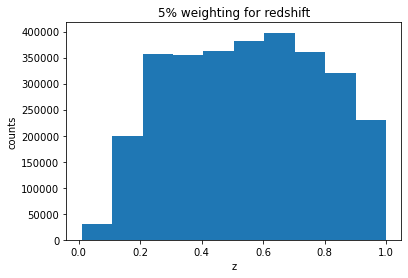

In [20]:
plt.hist(check_array[:,5])
plt.title("{:d}% weighting for redshift".format(int(percentage)))
plt.xlabel("z")
plt.ylabel("counts")

(0.0, 90000.0)

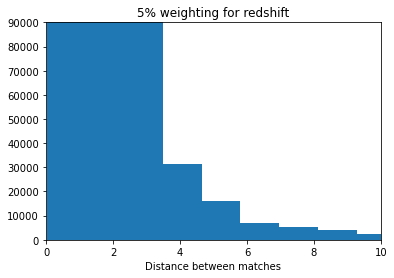

In [21]:
plt.hist(check_array[:,7], bins=15)
plt.xlabel("Distance between matches")
plt.title("{:d}% weighting for redshift".format(int(percentage)))
plt.xlim([0,10])
plt.ylim([0,90000])

# Find and remove duplicates

In [23]:
galaxy_ids = resampled_limit['galaxy_id'].to_numpy()[save_array[:,0].astype(int)]
# quick version. Takes only unique cosmoDC2 galaxies from array. Indices returns the first instance for any duplicate galaxy.
# Not good if you want to track closest nn distance.
unq, idx = np.unique(galaxy_ids, return_index=True)
check_array_uniques = check_array[idx]
save_array_uniques  = save_array[idx]
len(save_array_uniques)

IndexError: index 75594939 is out of bounds for axis 0 with size 75589123

In [37]:
# This version only necessary if you want to make sure the unique galaxies are the closest matches
galaxy_ids = resampled_limit['galaxy_id'].to_numpy()[save_array[:,0].astype(int)]
appears_once = [item for item, count in Counter(galaxy_ids).items() if count == 1]
dup_id = [item for item, count in Counter(galaxy_ids).items() if count > 1]
print("Found duplicates.")
c = 0
# copy all the 1-time-appearing galaxies over to save_array_uniques and check_array_uniques
for galid in appears_once:
    if c%1000 == 0:
        print(c/142000.)
    unq_idx = np.where(galaxy_ids==galid)[0]
    if c==0:
        save_array_uniques = np.reshape(save_array[unq_idx],(1,3))
        check_array_uniques = np.reshape(check_array[unq_idx],(1,8))
    else:
        save_array_uniques = np.append(save_array_uniques, np.reshape(save_array[unq_idx],(1,3)),axis=0)
        check_array_uniques = np.append(check_array_uniques,np.reshape(check_array[unq_idx],(1,8)),axis=0)
    c+=1
# find the closest-match versions of all the duplicates
c = 0
start = time.time()
for galid in dup_id:
    # find the match with the smallest distance
    if c%1000 == 0:
        print(c/142000.)    
    dup_idx = np.where(galaxy_ids==galid)[0]
    dist_dups  = save_array[:,2][dup_idx]
    idx_mindist = dup_idx[np.argmin(dist_dups)]
    save_array_uniques = np.append(save_array_uniques, np.reshape(save_array[idx_mindist],(1,3)),axis=0)
    check_array_uniques = np.append(check_array_uniques,np.reshape(check_array[idx_mindist],(1,8)),axis=0)
    c+=1
end = time.time()
print("time:", end-start)

len(dup_id), len(appears_once), len(dup_id)+len(appears_once), len(save_array_uniques)

Found duplicates.
0.0
0.0
time: 0.0026895999908447266


(68, 568, 636, 636)

In [38]:
# test that it worked
galaxy_ids_unq = resampled_limit['galaxy_id'].to_numpy()[save_array_uniques[:,0].astype(int)]
print(len(np.unique(galaxy_ids_unq)), len(galaxy_ids_unq))

636 636


/global/u2/m/mlokken/mydescdev/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/global/u2/m/mlokken/mydescdev/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


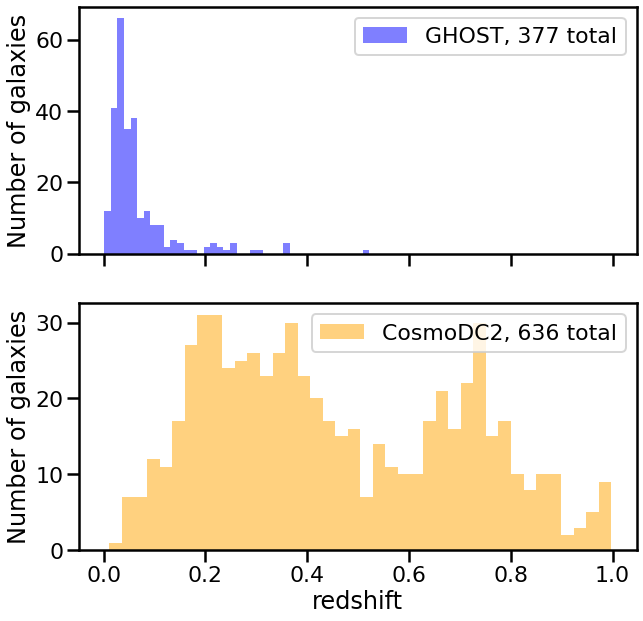

In [39]:
# plt.figure(figsize=[10,6])
if not os.path.exists('../plots/{:s}'.format(modestr)):
    os.mkdir('../plots/{:s}'.format(modestr))
sns.set_context("poster")
fig, ax = plt.subplots(nrows=2,ncols=1, figsize=[10,10], sharex=True)
ax[0].hist(ghost['TransientRedshift'],bins=40, alpha=0.5, color='blue', label='GHOST, {:d} total'.format(len(data_keyparams)))
ax[1].hist(resampled_limit['PZflowredshift'][save_array_uniques[:,0]],bins=40,alpha=0.5, color='orange', label='CosmoDC2, {:d} total'.format(len(save_array_uniques)))
plt.xlabel("redshift")
plt.legend()
ax[0].set_ylabel("Number of galaxies")
ax[1].set_ylabel("Number of galaxies")
ax[1].ticklabel_format(axis='y', style='sci')
ax[0].legend()
plt.savefig("../plots/{0}/cdc2_ghost_{0}_k{1}_lowz_weighting_matches_unq_histogram.png".format(modestr, n_neigh))


In [40]:
# check all properties against each other for CosmoDC2
labels=['R', 'I', 'g-r', 'i-z', 'ellipticity', 'redshift']
lims =[[-25,-14.5],[-25,-14.5],[-0.3,1.2],[-0.2,0.5],[0,0.4],[0,1]]
for i in range(6):
    for j in range(i+1,6):
        fig,ax = plt.subplots(nrows=2,ncols=1,figsize=[7,10],sharex=True)
        im2=ax[1].scatter(data_keyparams[:,j],data_keyparams[:,i],c=dist[:,0], cmap='plasma_r', alpha=0.5, s=1, vmin=0, vmax=3)
        im1=ax[0].scatter(check_array_uniques[:,j],check_array_uniques[:,i],c=check_array_uniques[:,7], cmap='plasma_r', alpha=0.2, s=1, vmin=0, vmax=3)
        ax[1].set_xlabel(labels[j])
        ax[0].set_ylabel(labels[i])
        ax[1].set_ylabel(labels[i])
        ax[0].set_title("CDC2 matched gals")
        ax[1].set_title("GHOST")
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        cbar = fig.colorbar(im1, cax=cbar_ax)
        cbar.set_label("distance")
        ax[0].set_xlim(lims[j])
        ax[1].set_xlim(lims[j])
        ax[1].set_ylim(lims[i])
        ax[0].set_ylim(lims[i])
        plt.savefig("../plots/{:s}/ghost_cdc2_k{:d}_lowz_weighting_unq_{:s}_vs_{:s}_{:s}.png".format(modestr,n_neigh,labels[i],labels[j],modestr), bbox_inches='tight')
        plt.clf()


<Figure size 504x720 with 0 Axes>

<Figure size 504x720 with 0 Axes>

<Figure size 504x720 with 0 Axes>

<Figure size 504x720 with 0 Axes>

<Figure size 504x720 with 0 Axes>

<Figure size 504x720 with 0 Axes>

<Figure size 504x720 with 0 Axes>

<Figure size 504x720 with 0 Axes>

<Figure size 504x720 with 0 Axes>

<Figure size 504x720 with 0 Axes>

<Figure size 504x720 with 0 Axes>

<Figure size 504x720 with 0 Axes>

<Figure size 504x720 with 0 Axes>

<Figure size 504x720 with 0 Axes>

<Figure size 504x720 with 0 Axes>

In [97]:
resamp_indices = save_array_uniques[:,0].astype(int)
galaxy_ids = resampled_limit['galaxy_id'].to_numpy()[resamp_indices]


In [98]:
# get bulges
# Load the CosmoDC2 galaxies 
cosmo = GCRCatalogs.load_catalog("cosmoDC2_v1.1.4_small")
filters=[(lambda x: np.in1d(x, galaxy_ids), 'galaxy_id')]
cdc2_data = cosmo.get_quantities(['size_minor_true', 'size_disk_true', 'size_minor_disk_true', 'size_bulge_true', 'size_minor_bulge_true', 'galaxy_id', 'sersic_disk', 'sersic_bulge', 'position_angle_true'], filters=filters)
# og_length   = len(cdc2_data['size_true'])
# print(og_length)
# c_idx = np.arange(0,og_length) # the whole list of original indices from this first data pull

In [99]:
# argsort to order save_array_uniques by galaxy_ids
sorted_idx = np.argsort(galaxy_ids)
save_array_uniques_neworder = save_array_uniques[sorted_idx]
sorted_dc2_idx = np.argsort(cdc2_data['galaxy_id'])
resamp_indices = save_array_uniques_neworder[:,0].astype(int)
galaxy_ids = resampled_limit['galaxy_id'].to_numpy()[resamp_indices]

galaxy_ids, cdc2_data['galaxy_id'][sorted_dc2_idx]

(array([ 6062500011,  6062500063,  6062500084, ..., 11940013067,
        11940016054, 11940021767]),
 array([ 6062500011,  6062500063,  6062500084, ..., 11940013067,
        11940016054, 11940021767]))

In [100]:
# save it all
save_dict = {
    'galaxy_id':resampled_limit['galaxy_id'].to_numpy()[resamp_indices], 'ra':resampled_limit['ra'].to_numpy()[resamp_indices],
            'dec':resampled_limit['dec'].to_numpy()[resamp_indices],
             'PZflowredshift':resampled_limit['PZflowredshift'].to_numpy()[resamp_indices], 'DC2redshift':resampled_limit['DC2redshift'].to_numpy()[resamp_indices], 'totalEllipticity':resampled_limit['morphology/totalEllipticity'].to_numpy()[resamp_indices],
             'PZflowSFRtot':resampled_limit['PZflowSFRtot'].to_numpy()[resamp_indices], 'DC2SFRtot':resampled_limit['DC2SFRtot'].to_numpy()[resamp_indices], 'Mag_true_g_sdss_z0':resampled_limit['Mag_true_g_sdss_z0'].to_numpy()[resamp_indices],
            'Mag_true_r_sdss_z0':resampled_limit['Mag_true_r_sdss_z0'].to_numpy()[resamp_indices], 'Mag_true_i_sdss_z0':resampled_limit['Mag_true_i_sdss_z0'].to_numpy()[resamp_indices],
            'Mag_true_z_sdss_z0':resampled_limit['Mag_true_z_sdss_z0'].to_numpy()[resamp_indices],
         'totalSersicIndex':resampled_limit['morphology/totalSersicIndex'].to_numpy()[resamp_indices], 'sersic_disk':cdc2_data['sersic_disk'][sorted_dc2_idx], 'sersic_bulge':cdc2_data['sersic_bulge'][sorted_dc2_idx],
    'size_true':resampled_limit['size_true'].to_numpy()[resamp_indices], 'size_bulge_true':cdc2_data['size_bulge_true'][sorted_dc2_idx], 'size_minor_true':cdc2_data['size_minor_true'][sorted_dc2_idx],
    'size_minor_bulge_true':cdc2_data['size_minor_bulge_true'][sorted_dc2_idx], 'size_disk_true':cdc2_data['size_disk_true'][sorted_dc2_idx],
    'size_minor_disk_true':cdc2_data['size_minor_disk_true'][sorted_dc2_idx], 'position_angle_true':cdc2_data['position_angle_true'][sorted_dc2_idx],
             'stellar_mass':resampled_limit['stellar_mass'].to_numpy()[resamp_indices],
    'GHOST_objID':ghost['objID'][save_array_uniques_neworder[:,1]], 
'GHOST_transientclass':ghost['TransientClass'][save_array_uniques_neworder[:,1]],
             'GHOST_ra':ghost['raMean'][save_array_uniques_neworder[:,1]], 'GHOST_dec':ghost['decMean'][save_array_uniques_neworder[:,1]], 'nn_distance':save_array_uniques_neworder[:,2]}
save_df = pd.DataFrame(save_dict)
save_df.to_csv('/global/cscratch1/sd/mlokken/sn_hostenv/cdc2_matched_ghost_{:s}_unq_zwgt_5pct_k{:d}.csv'.format(modestr, n_neigh), index=False)

Check that it worked

In [41]:
data=pd.read_csv('/global/cscratch1/sd/mlokken/sn_hostenv/cdc2_matched_ghost_{:s}_unq_zwgt_5pct_k{:d}.csv'.format(modestr,265))


In [42]:
check = 1014
ghost_objID = data['GHOST_objID'][check]
print(ghost['TransientRedshift'][ghost['objID']==ghost_objID],data['PZflowredshift'][check])
print(ghost['rKronMag_SDSS_abs'][ghost['objID']==ghost_objID],data['Mag_true_r_sdss_z0'][check])
print(ghost['iKronMag_SDSS_abs'][ghost['objID']==ghost_objID],data['Mag_true_i_sdss_z0'][check])
print(ghost['r_ellip'][ghost['objID']==ghost_objID],data['totalEllipticity'][check])
print(ghost['raMean'][ghost['objID']==ghost_objID], data['GHOST_ra'][check])

272    0.05402
Name: TransientRedshift, dtype: float64 0.4743635356426239
272   -22.616944
Name: rKronMag_SDSS_abs, dtype: float64 -21.848694
272   -22.816473
Name: iKronMag_SDSS_abs, dtype: float64 -22.322428
272    0.043027
Name: r_ellip, dtype: float64 0.10366632
272    131.235977
Name: raMean, dtype: float64 131.23597661


Text(0, 0.5, '$\\log_{10}SFR [\\mathrm{M}_\\odot/yr]$')

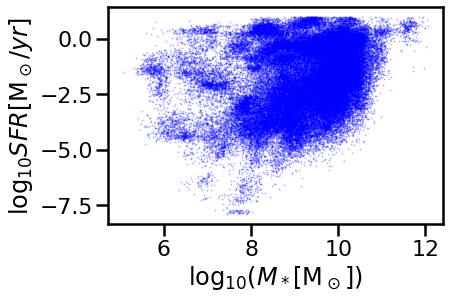

In [43]:
plt.plot(np.log10(data['stellar_mass']),np.log10(data['PZflowSFRtot']/10**9), 'bo', alpha=.2, markersize=1)
plt.xlabel(r"$\log_{10}(M_* [\mathrm{M}_\odot])$")
plt.ylabel(r"$\log_{10}SFR [\mathrm{M}_\odot/yr]$")

In [44]:
len(data)

69279